<a href="https://colab.research.google.com/github/tutorials101/micrograd/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<> Micrograd Engine Re-Implementation; I'm gonna call it **Scalargrad** instead. You may ask why? I mean why not...? lol

This is my effort to learn and improve my knowledge and skills

ref: https://youtu.be/VMj-3S1tku0?si=yOYgVsaueCvW9oDB

**Logs**: Bugs that I came across while building the engine

*   Forgot to accumulate gradients for some operation; did "grad =" instead of "grad += "
*   Stupid mistake, insted of out node, I assigned the backprop function to self node. Don't ask me why! It was chatgpt who found the error..
* Also learned how \__r*__(self, other) function works, For eg, for \__rsub__(self, other) called for constant - ScalarObject, where self=ScalarObject and other=constant; now to actually do the operation, you should do -self + constant




In [255]:
# computational graph visualization
from graphviz import Digraph

def trace(node):

  nodes, edges = set(), set()

  def parse(node):
    if node not in nodes:
      nodes.add(node)

    for parent in node.parents:
      if (parent, node) not in edges:
        edges.add((parent, node))
      parse(parent)

  parse(node)

  return nodes, edges

def draw_graph(node):

  dot = Digraph(graph_attr={'rankdir':'LR'})
  nodes, edges = trace(node)

  for node in nodes:
    if node.label:
      dot.node(name=str(id(node)), label="{ %s | data=%.2f | grad=%.2f }" % (node.label, node.data, node.grad), shape='record')
    else:
      dot.node(name=str(id(node)), label="{data=%.2f | grad=%.2f }" % (node.data, node.grad), shape='record')
    if node.operator:
      dot.node(name=str(id(node))+node.operator, label=node.operator)
      dot.edge(str(id(node))+node.operator, str(id(node)))


  for (node1, node2) in edges:
    dot.edge(str(id(node1)), str(id(node2))+node2.operator)


  return dot





In [256]:
# building blocks

import math

class Scalar:

  def __init__(self, data, parents=(), operator='', label=''):
    self.data = data
    self.grad = 0.0
    self.parents = parents
    self.operator = operator
    self.label = label
    self.backprop = lambda: None

  def __repr__(self):
    return f"Scalar(data={self.data:0.2f}, grad={self.grad:0.2f})"

  #scalar operations
  def __add__(self, other):

    if not isinstance(other, Scalar):
      other = Scalar(other)
    out = Scalar(self.data + other.data, parents=(self, other), operator='+')

    def backprop():
      self.grad += out.grad
      other.grad += out.grad
    out.backprop = backprop

    return out

  def __radd__(self, other):
    return self + other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):

    if not isinstance(other, Scalar):
      other = Scalar(other)
    return self + (-other)

  def __rsub__(self, other): # other - self
    return (-self) + other


  def __mul__(self, other):

    if not isinstance(other, Scalar):
      other = Scalar(other)
    out = Scalar(self.data*other.data, parents=(self, other), operator='*')

    def backprop():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out.backprop = backprop

    return out

  def __rmul__(self, other):
    return self * other

  def exp(self):
    out = Scalar(math.exp(self.data), parents=(self,), operator='exp')

    def backprop():
      self.grad += out * out.grad
    out.backprop = backprop

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only support int or float exponents"
    out = Scalar(self.data**other, parents=(self,), operator=f"^{other}")

    def backprop():
      self.grad += (other * self.data**(other-1))*out.grad

    out.backprop = backprop

    return out

  def __truediv__(self, other):
    if not isinstance(other, Scalar):
      other = Scalar(other)
    out = self * (other**-1)

    return out

  def __rtruediv__(self, other):
    return (self**-1) * other

  def tanh(self):
    out = Scalar(math.tanh(self.data), parents=(self,), operator='tanh')

    def backprop():
      self.grad += (1-out.data**2) * out.grad
    out.backprop = backprop

    return out

  def relu(self):
    out = Scalar(max(self.data, 0), parents=(self,), operator='relu')

    def backprop():
      self.grad += (out.data>0) * out.grad

    out.backprop = backprop

    return out

  def backward(self):

    sorted_nodes = []
    visited_nodes = set()
    def sort_node(node):
      if node not in visited_nodes:
        visited_nodes.add(node)
        for parent in node.parents:
          sort_node(parent)
        sorted_nodes.append(node)
    sort_node(self)

    self.grad = 1.0
    for node in reversed(sorted_nodes):
      node.backprop()




In [ ]:
# Sanity check - ref: https://github.com/karpathy/micrograd/blob/master/test/test_engine.py

In [258]:
import torch

def test_sanity_check():

    x = Scalar(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    assert xmg.grad == xpt.grad.item()

def test_more_ops():

    a = Scalar(-4.0)
    b = Scalar(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    # backward pass went well
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol

test_sanity_check()
test_more_ops()

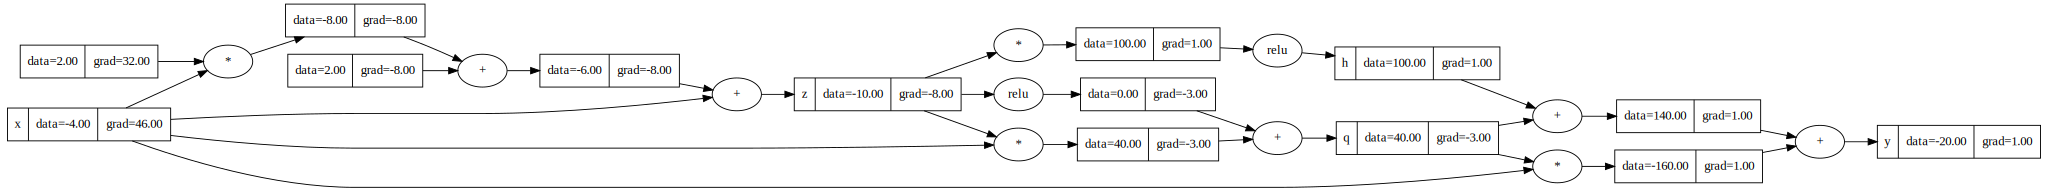

46.0 -8.0 -3.0 1.0 1.0
46.0 -8.0 -3.0 1.0 1.0


In [260]:
x = Scalar(-4.0, label='x')
z = 2 * x + 2 + x
z.label='z'
q = z.relu() + z * x
q.label='q'
h = (z * z).relu()
h.label='h'
y = h + q + q * x
y.label='y'
y.backward()


display(draw_graph(y))

print(x.grad, z.grad, q.grad, h.grad, y.grad)

xmg, ymg = x, y

x = torch.Tensor([-4.0]).double()
x.requires_grad = True
z = (2 * x + 2 + x)
z.retain_grad()


q = (z.relu() + z * x)
q.retain_grad()
h = ((z * z).relu())
h.retain_grad()
y = h + q + q * x
y.retain_grad()
y.backward()
xpt, ypt = x, y

print(x.grad.item(), z.grad.item(), q.grad.item(), h.grad.item(), y.grad.item())
